In [510]:
import math
from itertools import groupby
import collections
import numpy as np
import matplotlib.pyplot as plt
import itertools 
import pylab as pl
from matplotlib import collections  as mc
import sys

# Input processing

In [512]:
name ='chicago'

In [513]:
f = open(name+'A.txt')
fcontents = f.read()
# can delete
# print(type(fcontents))
# print(fcontents)

In [514]:
def split_line(text):
    # split the text
    words = text.split()
    answer = [] 
    # for each word in the line:
    for word in words:
        # print the word
        answer.append(word)
    return answer

In [515]:
def coerce_int(text):
    answer= []
    for word in text:
        answer.append(int(word))
    return answer

In [516]:
edge = coerce_int(split_line(fcontents)) # an integer array of length 2*e of edge information, 1-start
n = max(edge)
e = int(len(edge)/2)
for i in range(len(edge)):
    edge[i] -= 1
# now edge is 0-start. It will remain this way.

# Creating edge and vertex objects

In [517]:
class Edge(object):
#    def method_a(self, foo):
#        print (self.x + ' ' + foo)
    def __init__(self): 
        self.x = "hello" # can delete
        self.invertex = -1
        self.outvertex = -1
        self.edgeWeight = -1
        self.edgePQ = -1
#arr[1].method_a('Sailor!')  # can delete

In [518]:
class Vertex(object):
    def __init__(self):
        self.degree = -1
        self.rep = -1 # with the next segment, the rep will just be itself at the beginning
        self.componentSize = 0 # will update later
        self.death = -1
        self.index = -1 # the index is itself. We might not need to use this ever. Could delete, if not needed
        self.merge = -1 # in the end, merge == -1 if either the vertex is the main branch, or if it got merged along as a byproduct of another vertex merging 
        self.branchSize = [1] # will update later
        self.branchTime = [-1]
        self.mergeTime = -1 # TODO fill in below. Mark this the weight of the weidge when it's first merged
        self.uniqueBranchTime = []
        self.uniqueBranchSize = []
    def equal(self,v):
        if v.index == self.index:
            return True
        return False

In [519]:
arrV  = [Vertex() for i in range(n)]
for i in range(n):
    arrV[i].rep = i
    arrV[i].index = i

In [520]:
arrE  =[Edge() for i in range(e)]
for i in range(int(len(edge)/2)):
    if edge[2*i] < edge[2*i+1]:
        arrE[i].invertex = edge[2*i]
        arrE[i].outvertex = edge[2*i+1]
    else:
        arrE[i].invertex = edge[2*i+1]
        arrE[i].outvertex = edge[2*i]

# Cleaning up edges: deleting non-unique edges 
# (can ignore if no non-unique edge)

In [521]:
tmp1 = []
tmp2 = []
for i in range(int(len(edge)/2)-1):
    if edge[2*i] < edge[2*i+1]:
        tmp1.append(edge[2*i])
        tmp2.append(edge[2*i+1])
    else:
        tmp2.append(edge[2*i])
        tmp1.append(edge[2*i+1])

In [522]:
adjMatrix = [[0 for i in range(n)] for j in range(n)]
for i in range(int(len(edge)/2)):
    if edge[2*i] < edge[2*i+1]:
        adjMatrix[edge[2*i]][edge[2*i+1]] +=1
    else:
        adjMatrix[edge[2*i+1]][edge[2*i]] +=1
uniqueEdge=[]
for i in range(n):
    for j in range(n):
        if adjMatrix[i][j] != 0:
            uniqueEdge.append(i)
            uniqueEdge.append(j)

In [523]:
edge = uniqueEdge
e = int(len(edge)/2)
arrE  =[Edge() for i in range(e)]
for i in range(int(len(edge)/2)):
    if edge[2*i] < edge[2*i+1]:
        arrE[i].invertex = edge[2*i]
        arrE[i].outvertex = edge[2*i+1]
    else:
        arrE[i].invertex = edge[2*i+1]
        arrE[i].outvertex = edge[2*i]

# Setting up vertex degree, edge weights, edge priority queue

In [524]:
degreeCounter  = collections.Counter(uniqueEdge) # be CAREFUL. Here I use uniqueEdge. Don't need to if dne non-unique edges
for i in range(n):
    arrV[i].degree = degreeCounter.get(i)
    arrV[i].branchTime[0] = arrV[i].degree
for i in range(e):
    arrE[i].edgeWeight = min(arrV[arrE[i].invertex].degree,arrV[arrE[i].outvertex].degree )

In [525]:
arrEdgeWeight = []
for i in range(e):
    arrEdgeWeight.append(arrE[i].edgeWeight)

In [526]:
arrEdgePQ = sorted(range(len(arrEdgeWeight)), key=lambda k:arrEdgeWeight[k])
for i in range(e):
    arrE[arrEdgePQ[i]].edgePQ = e-1-i #0-start

In [527]:
arrEdgePQ = [0]*e
for i in range(e):
    arrEdgePQ[arrE[i].edgePQ] = i

# Union-find

In [528]:
def get_last(a):
    return a[len(a)-1]
def get(a,t): # specific for the usage below
    if t == len(a):
        return -2;
    else: return a[t]

In [529]:
# disjoint-set union-find, comparing rep's degree. Merge to the larger degreed rep.
for k in range(e):
    i = arrEdgePQ[k]
    currE = arrE[i] # edges are stored in an array of edges, called arrE. This is an index.
    w=currE.outvertex # index of the out-vertex
    v= currE.invertex # index of the in-vertex
    repV = arrV[v].rep # vertices are stored in an array of vertices, called arrV. This is an index.
    repW = arrV[w].rep # This is an index.
    if arrV[v].rep != arrV[w].rep: 
        branchCounter = 0
        
        if arrV[repV].degree >= arrV[repW].degree: # union by degree
            #print(str(repW) + ' '+str(w) + ' '+ str(v))
            if arrV[w].mergeTime == -1:
                arrV[w].mergeTime = currE.edgeWeight
            if arrV[repW].mergeTime == -1:
                arrV[repW].mergeTime = currE.edgeWeight
            for j in range(n):
                if arrV[j].rep == repW:
                    arrV[j].rep = repV
                    if arrV[j].death == -1: # update vertex death time
                        arrV[j].death = arrE[i].edgeWeight
                        arrV[j].merge = repV
                    elif currE.edgeWeight == arrV[j].mergeTime:
                        arrV[j].merge = repV
            branchCounter += get_last(arrV[repW].branchSize)
            arrV[repW].branchSize.append(0)
            arrV[repV].branchSize.append(get_last(arrV[repV].branchSize) + branchCounter)
            arrV[repV].branchTime.append(currE.edgeWeight)
            arrV[repW].branchTime.append(currE.edgeWeight)
            
        else: 
                #print(str(repV) + ' '+str(v) + ' '+ str(w))
                if arrV[w].mergeTime == -1:
                    arrV[w].mergeTime = currE.edgeWeight
                if arrV[repW].mergeTime == -1:
                    arrV[repW].mergeTime = currE.edgeWeight
                for j in range(n):
                    if arrV[j].rep == repV:
                        arrV[j].rep = repW      
                        if arrV[j].death == -1: # update vertex death time
                            arrV[j].death = arrE[i].edgeWeight
                            arrV[j].merge = repW
                        elif currE.edgeWeight == arrV[j].mergeTime:
                            arrV[j].merge = repW
                branchCounter += get_last(arrV[repV].branchSize)
                arrV[repV].branchSize.append(0)
                arrV[repW].branchSize.append(get_last(arrV[repW].branchSize) +branchCounter)
                arrV[repV].branchTime.append(currE.edgeWeight)
                arrV[repW].branchTime.append(currE.edgeWeight)

In [531]:
# count component sizes 
for i in range(n):
    arrV[arrV[i].rep].componentSize +=1

In [532]:
for i in range(n):
    currV = arrV[i]
    currLen = len(currV.branchTime)
    #print(str(i) +' ' + str(currV.branchTime) + ' ' + str(currLen))
    for j in range(currLen):
        if get(currV.branchTime, j) != get(currV.branchTime, j+1):
            arrV[i].uniqueBranchTime.append(get(currV.branchTime,j))
            arrV[i].uniqueBranchSize.append(get(currV.branchSize,j))

# Printing union-find results out, mostly for debugging

In [537]:
# reference
# pyformat:  https://pyformat.info/
# http://stackoverflow.com/questions/8234445/python-format-output-string-right-alignment
for i in range(n):
        #print('{:>5} {:>5} {:>5} {:>5} {:>5} {:>5} {:>5} {:>20} {:>20} {:>20} {:>20}'.format(str(i), str(arrV[i].componentSize),str(arrV[i].mergeTime), str(arrV[i].rep), str(arrV[i].degree),str(arrV[i].death) , str(arrV[i].merge),   str(arrV[i].branchSize),str(arrV[i].branchTime), str(arrV[i].uniqueBranchSize), str(arrV[i].uniqueBranchTime)  ))
        sys.stdout.write('{:>5} {:>5} {:>5} {:>5} {:>5} {:>5} {:>5} {:>30} {:>30}'.format(str(i), str(arrV[i].componentSize),str(arrV[i].mergeTime), str(arrV[i].rep), str(arrV[i].degree),str(arrV[i].death) , str(arrV[i].merge),   str(arrV[i].uniqueBranchSize), str(arrV[i].uniqueBranchTime)))
        #print('{:>5} {:>5} {:>5} {:>5} {:>5} {:>5} {:>5} {:>20} {:>20}'.format(str(i), str(arrV[i].componentSize),str(arrV[i].mergeTime), str(arrV[i].rep), str(arrV[i].degree),str(arrV[i].death) , str(arrV[i].merge),   str(arrV[i].uniqueBranchSize), str(arrV[i].uniqueBranchTime)  ))
        #sys.stdout.write('{:>5} {:>5} {:>5} {:>5} {:>5} {:>5} {:>5}'.format(str(i), str(arrV[i].componentSize),str(arrV[i].mergeTime), str(arrV[i].rep), str(arrV[i].degree),str(arrV[i].death) , str(arrV[i].merge)))
        sys.stdout.write('\n')

    0     0    -1   589     1     1   589                            [0]                            [1]
    1     0     1   589     8     8     9                            [0]                            [8]
    2     0     1   589     1     1   589                            [0]                            [1]
    3     0     1   589     1     1   589                            [0]                            [1]
    4     0     1   589     1     1   589                            [0]                            [1]
    5     0     1   589     1     1   589                            [0]                            [1]
    6     0     1   589     1     1   589                            [0]                            [1]
    7     0     1   589     1     1   589                            [0]                            [1]
    8     0    -1   589     1     1   589                            [0]                            [1]
    9     0    10   589    11     5   952        [40, 42, 43, 44

#sys.stdout.write(str(99) + '\n')
#for line in [[1, 128, 1298039], [123388, 0, 2]]:print('{:>8} {:>8} {:>8}'.format(*line))
word = [100,12,3]
word1 = [100,56734352,3]
print( '%12s  %12s  %12s' % (word[0], word[1], word[2]))
print( '%12s  %12s  %12s' % (word1[0], word1[1], word1[2]))
print('{:>12}  {:>12}  {:>12}'.format(word[0], word[1], word[2]))
print('{:>12}  {:>12}  {:>12}'.format(word1[0], word1[1], word1[2]))

In [552]:
birthArr = []
deathArr = []
for i in range(n):
    if arrV[i].degree != get_last(arrV[i].uniqueBranchTime):
        birthArr.append(arrV[i].degree)
        deathArr.append(get_last(arrV[i].uniqueBranchTime))

In [553]:
len(birthArr)

36

In [554]:
len(deathArr)

36

In [558]:
birthArr

[11,
 2,
 2,
 2,
 11,
 11,
 11,
 11,
 12,
 11,
 11,
 11,
 3,
 11,
 11,
 3,
 3,
 12,
 11,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [560]:
deathArr

[5,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 5,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [572]:
scratch = sorted(zip(birthArr,deathArr))
newB = [int(i[0]) for i in scratch]
newD= [int(i[1]) for i in scratch]

In [573]:
len(newB)

36

In [574]:
# reference: draw graphs
# http://stackoverflow.com/questions/6834483/how-do-you-create-line-segments-between-two-points
# http://stackoverflow.com/questions/21352580/matplotlib-plotting-numerous-disconnected-line-segments-with-different-colors
#lines = [[(0, 1), (1, 1)], [(2, 3), (3, 3)], [(1, 2), (1, 3)], [[3,4],[5,6]]]

segs = np.zeros((len(newB),2,2),int)
segs[:,0,1] = range(len(newD))
segs[:,1,0] = newB #birth
segs[:,1,1] = range(len(newD))
segs[:,0,0] = newD #death

#  segs
# [[[000 D0, 001 B0],[010 B0, 011 B0]],
#  [[100 D1, 101 B1],[110 B1, 111 B1]],
#  [[200 D2, 201 B2],[210 B2, 211 B2]]]
c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
lc = mc.LineCollection(segs, colors=c, linewidths=2)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.title(name+'Persistence')
pl.savefig(name+'P.png', bbox_inches='tight')
#plt.show()

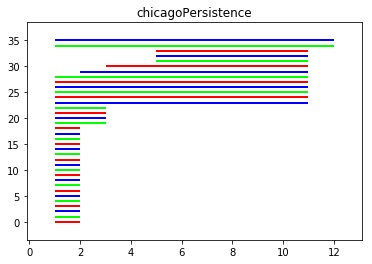

In [575]:
plt.show()

# Interpreting results + Graphing 
# TODO (algo updated above, this part not yet) 

In [35]:
# reference
# http://www.pythonforbeginners.com/files/reading-and-writing-files-in-python
# http://stackoverflow.com/questions/2967194/open-in-python-does-not-create-a-file-if-it-doesnt-exist
file = open(name+'D.txt', 'w+')
for i in range(n):
    file.write(str(i) + ','+ str(arrV[i].componentSize)+','+str(arrV[i].rep) + ','+str(arrV[i].degree)+','+str(arrV[i].death) + ','+str(arrV[i].merge)+','+str(arrV[i].branchSize)+','+str(arrV[i].branchTime))
    file.write('\n')
file.close() 

In [36]:
birthArr = []
deathArr = []
for i in range(n):
    birthArr.append(arrV[i].degree)
    deathArr.append(arrV[i].death)

In [37]:
# reference: draw graphs
# http://stackoverflow.com/questions/6834483/how-do-you-create-line-segments-between-two-points
# http://stackoverflow.com/questions/21352580/matplotlib-plotting-numerous-disconnected-line-segments-with-different-colors
#lines = [[(0, 1), (1, 1)], [(2, 3), (3, 3)], [(1, 2), (1, 3)], [[3,4],[5,6]]]

segs = np.zeros((n,2,2),int)
segs[:,0,1] = birthArr #birth
segs[:,1,0] = birthArr #birth
segs[:,1,1] = birthArr #birth
segs[:,0,0] = deathArr #death

#  segs
# [[[000 D0, 001 B0],[010 B0, 011 B0]],
#  [[100 D1, 101 B1],[110 B1, 111 B1]],
#  [[200 D2, 201 B2],[210 B2, 211 B2]]]
c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
lc = mc.LineCollection(segs, colors=c, linewidths=2)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.title(name+'Persistence')
pl.savefig(name+'P.png', bbox_inches='tight')
#plt.show()

In [38]:
# for reference
#import matplotlib.pyplot as plt
#import itertools 

#fig=plt.figure()
#ax=fig.add_subplot(111)
#all_data = [[1,10],[2,10],[3,10],[4,10],[5,10],[3,1],[3,2],[3,3],[3,4],[3,5]]
#plt.plot(
#    *zip(*itertools.chain.from_iterable(itertools.combinations(all_data, 2))),
#    color = 'brown', marker = 'o')

#pylab.savefig('foo.png', bbox_inches='tight')
#plt.show()
#pylab.savefig('foo.png', bbox_inches='tight')

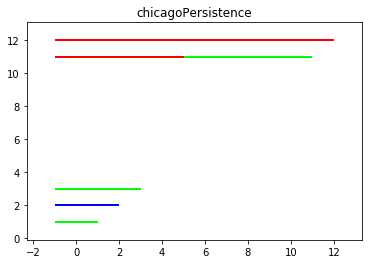

In [39]:
plt.show()

In [40]:
# for safety check
#for i in range(n):
#    if arrV[i].degree is None:
#        print(i)

In [41]:
maxBranchLength = 0
maxBranchIndex = -1
for i in range(n):
    tmp = len(arrV[i].branchSize)
    if maxBranchLength < tmp:
        maxBranchIndex = i
        maxBranchLength = tmp

In [42]:
# reference: both save graph and plot graph / plot color
# http://stackoverflow.com/questions/21875356/saving-a-figure-after-invoking-pyplot-show-results-in-an-empty-file
# http://matplotlib.org/api/colors_api.html
plt.plot(arrV[maxBranchIndex].branchSize, color  = 'g')
plt.title(name+': size Growth of the longest Branch')
plt.ylabel('y = the number of nodes in the branch')
plt.xlabel('x = the number of updates')
plt.savefig(name+'GB.png', bbox_inches='tight')

# scratch

In [558]:
from ete2 import Tree, TreeStyle
t = Tree()
t.populate(10, random_dist=True)
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_length = True
ts.show_branch_support = True
t.show(tree_style=ts)

ImportError: No module named 'ete2'